In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchvision.transforms.transforms import ToPILImage
from skimage import io

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

#Custom models
from Model.device import device
from Model.custom_dataset_test import CustomDataTransform_test

from Model.generator import Generator
from Model.discriminator import Discriminator

from Model.train_disc import train_discriminator
from Model.train_gen import train_generator

from Model.train_step import train_step
from Model.valid_step import valid_step
from Model.visualization import visual

C:\Users\yaigo\Anaconda3\envs\Exponenta\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\yaigo\Anaconda3\envs\Exponenta\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = device()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [3]:
source_dir = 'data/us'
list_dir = os.listdir(source_dir)
list_pd = []
for file_name in list_dir:
    list_pd.append(file_name)
df = pd.DataFrame(list_pd)

x_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

y_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

dataset = CustomDataTransform_test(df, features_transform=x_transform, label_transform=y_transform)
batch_size = 14

#train_lenght = int(len(dataset)*part)
#valid_lenght = int(len(dataset) - train_lenght)

#train_set, valid_set = random_split(dataset, [train_lenght, valid_lenght])
#train_loader = DataLoader(train_set, batch_size=batch_size, drop_last=False, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False, shuffle=True)

#print(f'Length of train is {len(train_set)}')
#print(f'Length of valid is {len(valid_set)}')
print(f'Length of valid is {len(test_loader)}')

Length of valid is 4


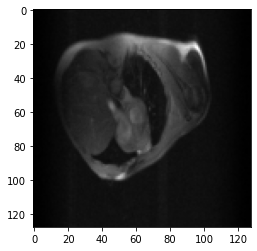

In [4]:
plt.imshow(dataset[0][1][0], cmap='gray')

In [5]:
#Loading model
PATH = 'learned_nets/extended_loss_v2/GAN_Gen_extended_v2.pt'
gen = Generator(in_channels=1, features=64).to(device)
gen.load_state_dict(torch.load(PATH))
gen.eval()

Generator(
  (initial_down): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (down1): Block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down2): Block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (down3): Block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, pa

In [6]:
in_x = torch.randn(14,1,128,128).to(device)
torch.onnx.export(gen, in_x, "gen.onnx", verbose=True)

graph(%input.1 : Float(14, 1, 128, 128, strides=[16384, 16384, 128, 1], requires_grad=0, device=cuda:0),
      %initial_down.0.weight : Float(64, 1, 2, 2, strides=[4, 4, 2, 1], requires_grad=1, device=cuda:0),
      %initial_down.0.bias : Float(64, strides=[1], requires_grad=1, device=cuda:0),
      %bottleneck.0.weight : Float(512, 512, 4, 4, strides=[8192, 16, 4, 1], requires_grad=1, device=cuda:0),
      %bottleneck.0.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %up1.conv.0.weight : Float(512, 512, 3, 3, strides=[4608, 9, 3, 1], requires_grad=1, device=cuda:0),
      %up1.conv.1.weight : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %up1.conv.1.bias : Float(512, strides=[1], requires_grad=1, device=cuda:0),
      %up1.conv.1.running_mean : Float(512, strides=[1], requires_grad=0, device=cuda:0),
      %up1.conv.1.running_var : Float(512, strides=[1], requires_grad=0, device=cuda:0),
      %up2.conv.0.weight : Float(1024, 512, 3, 3, strides=[

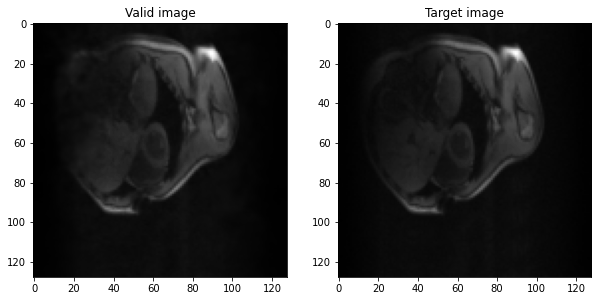

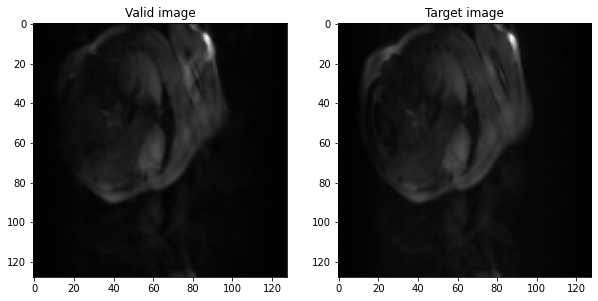

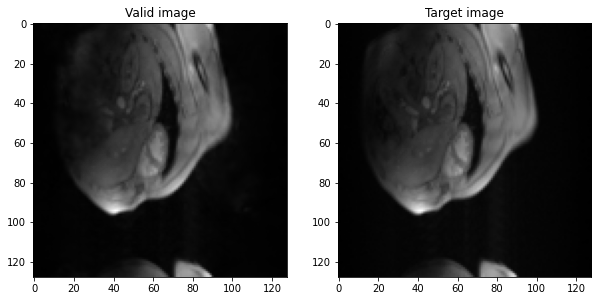

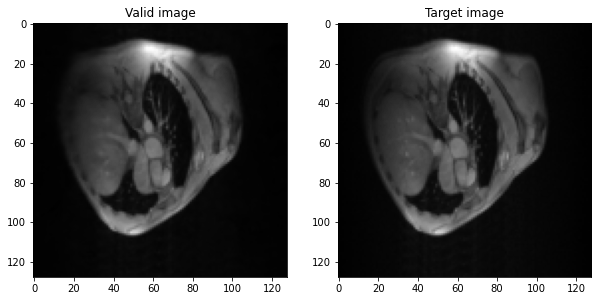

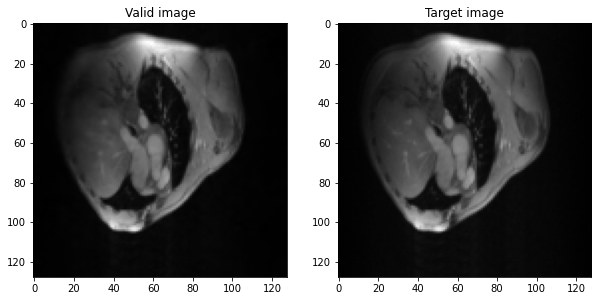

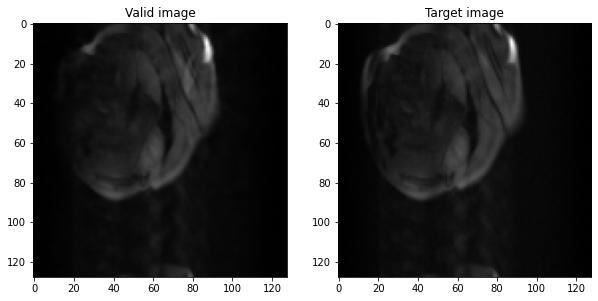

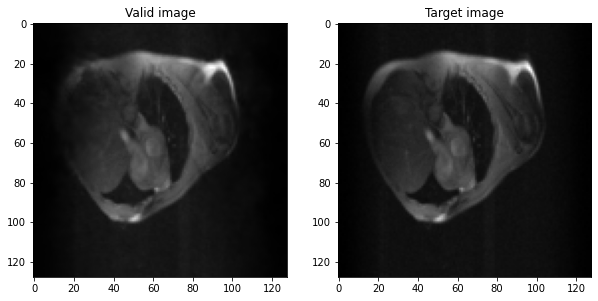

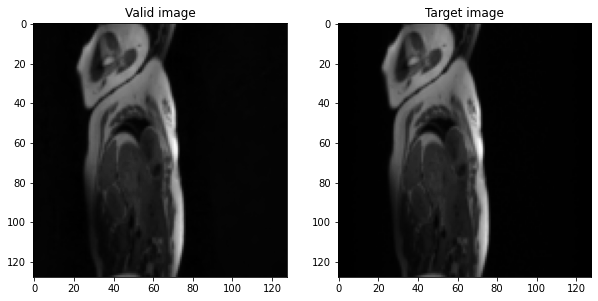

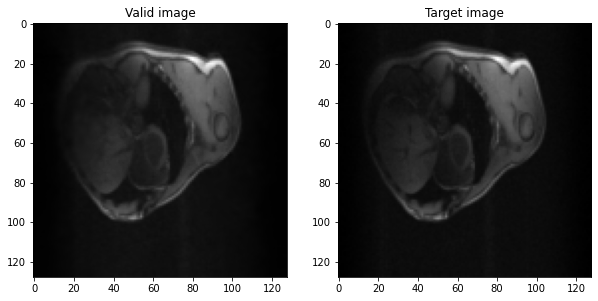

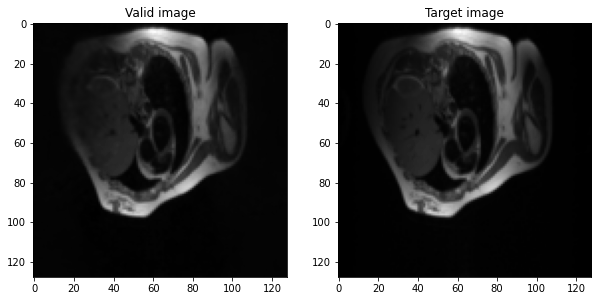

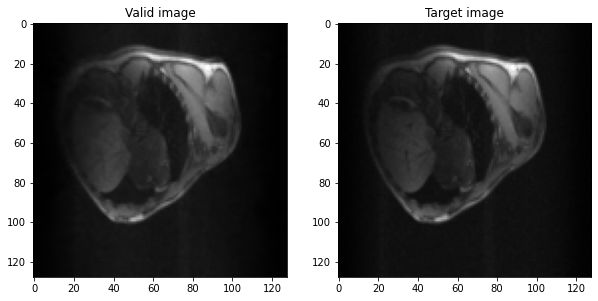

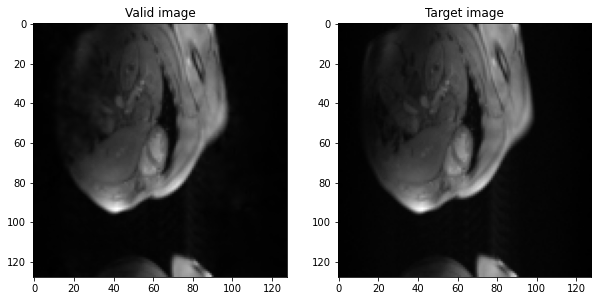

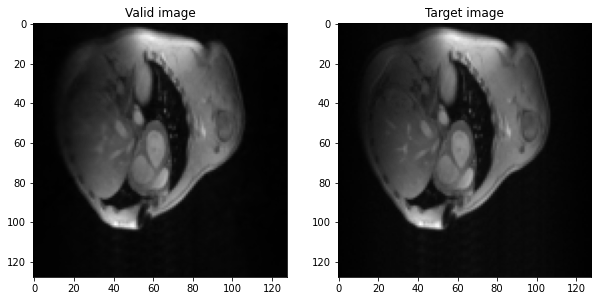

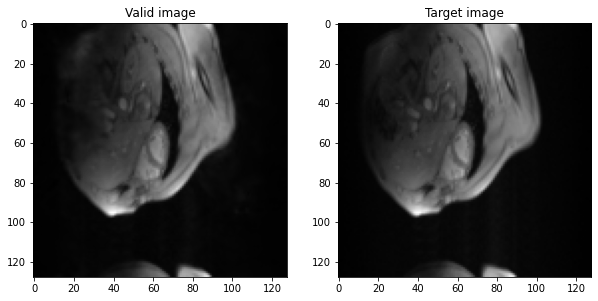

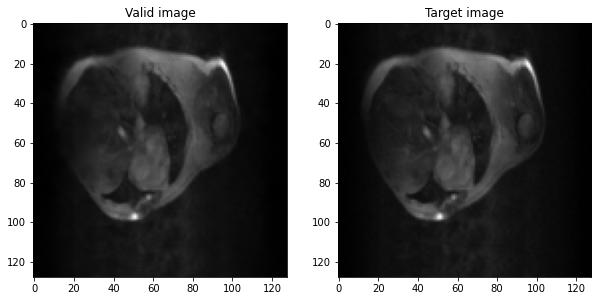

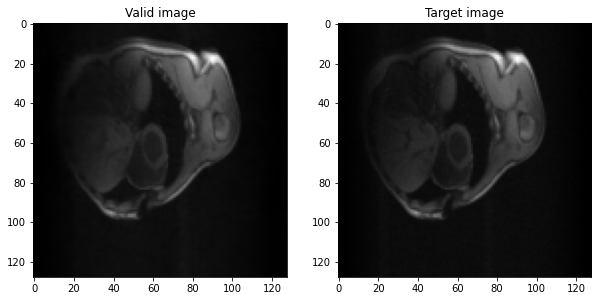

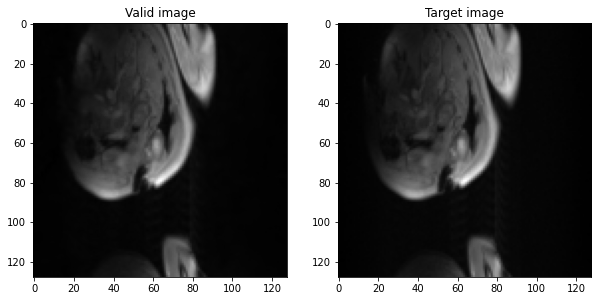

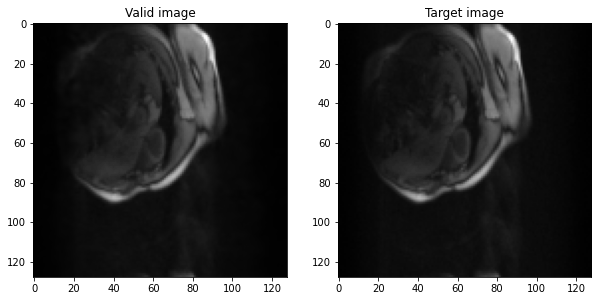

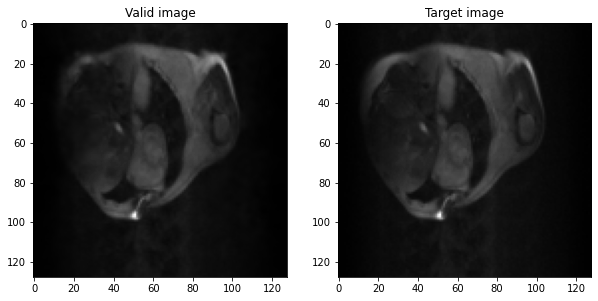

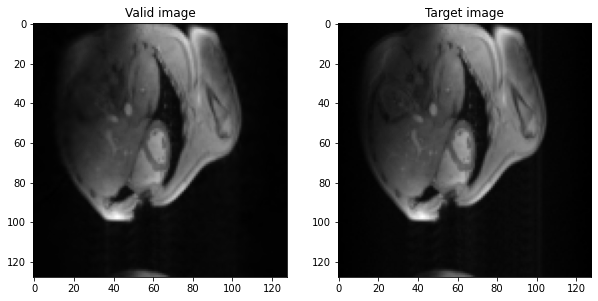

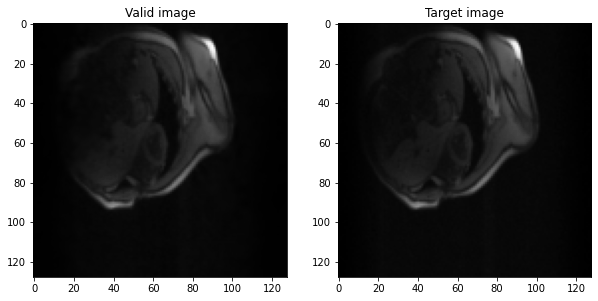

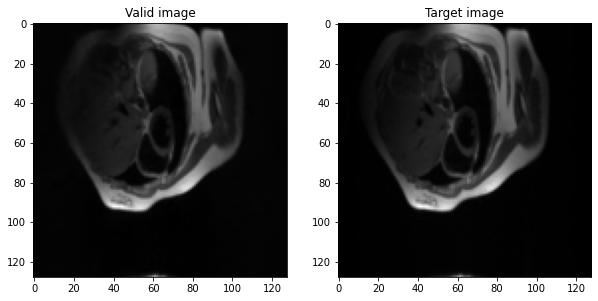

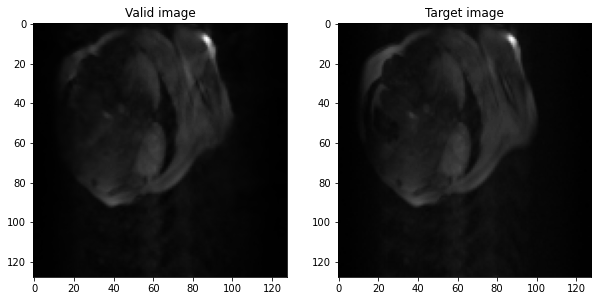

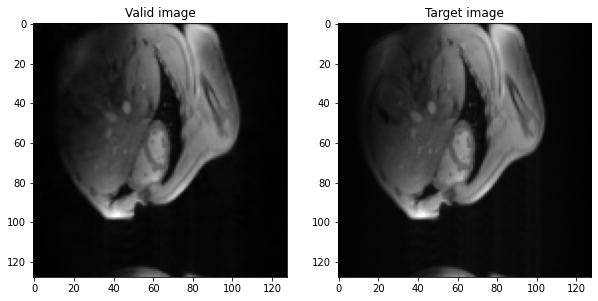

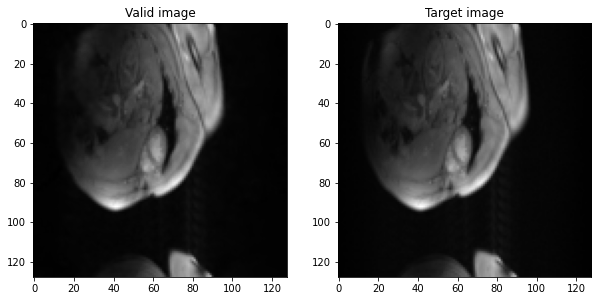

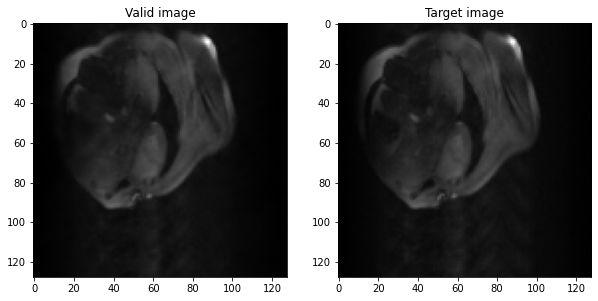

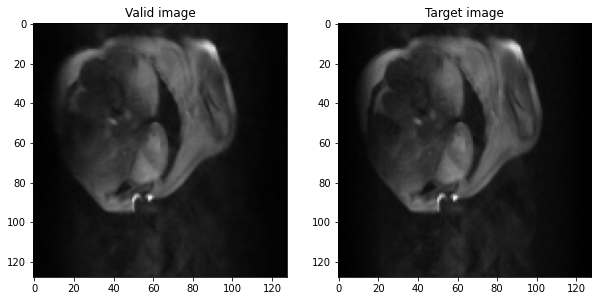

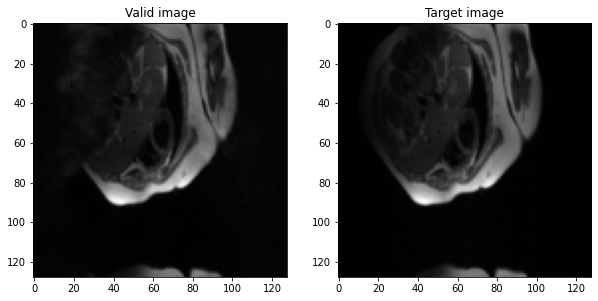

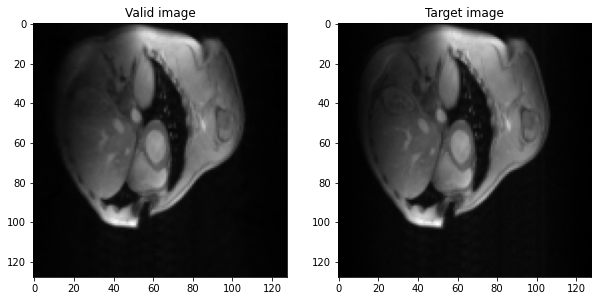

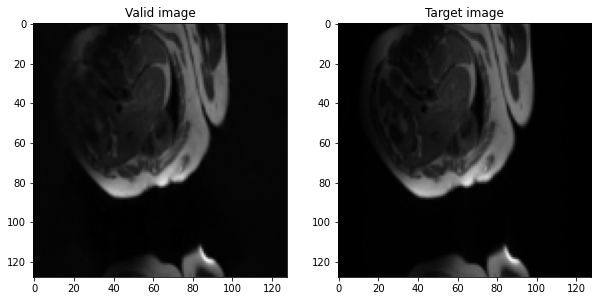

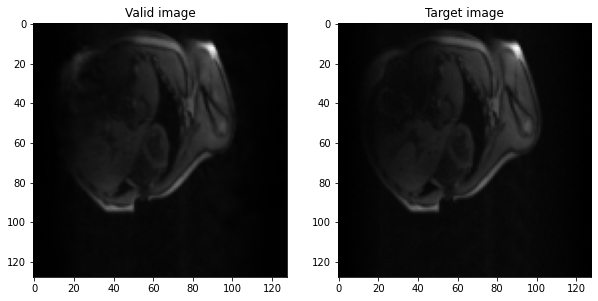

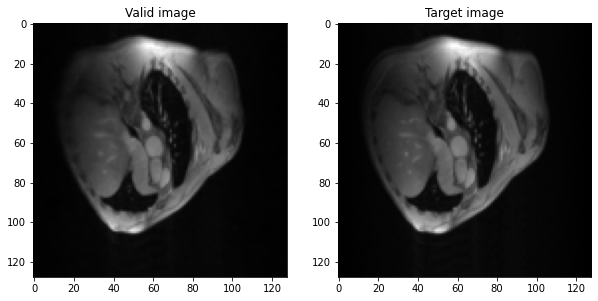

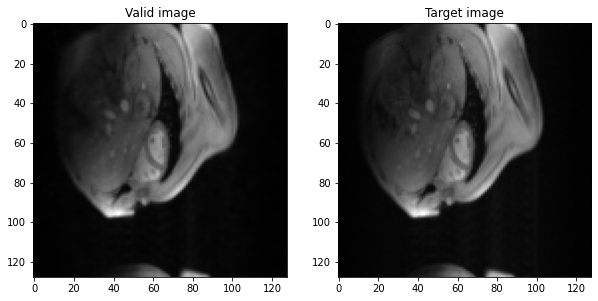

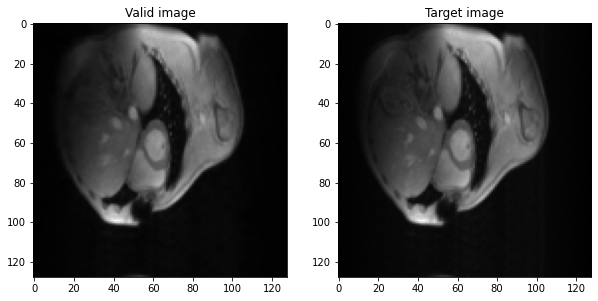

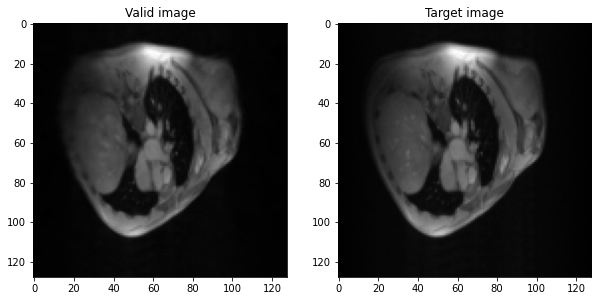

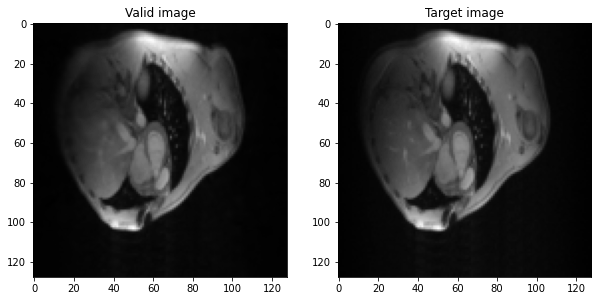

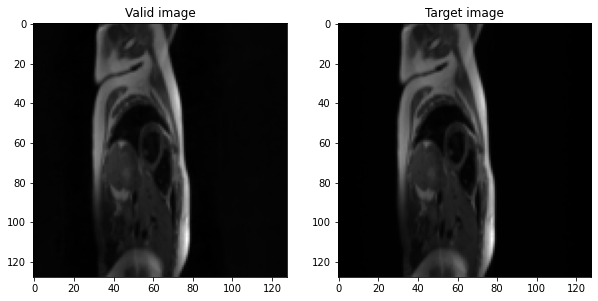

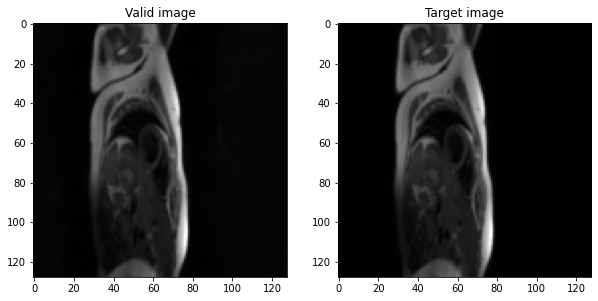

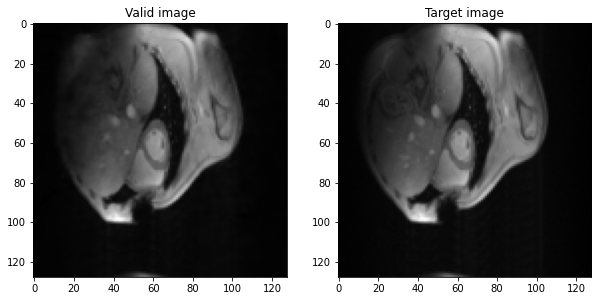

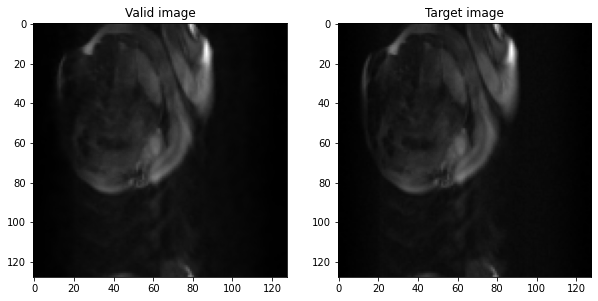

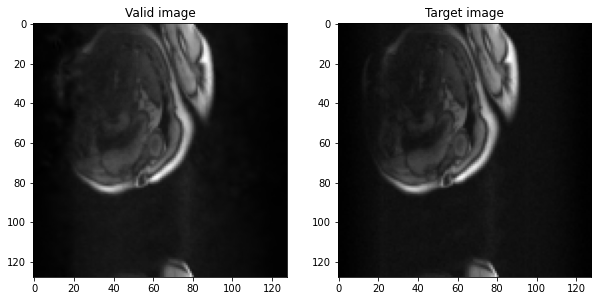

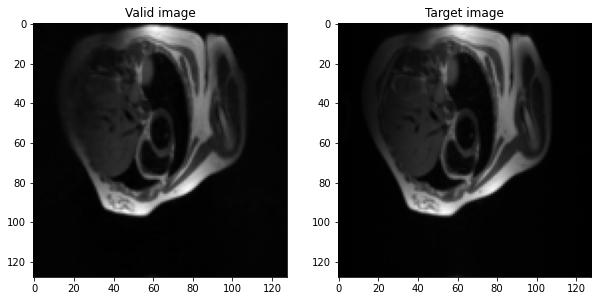

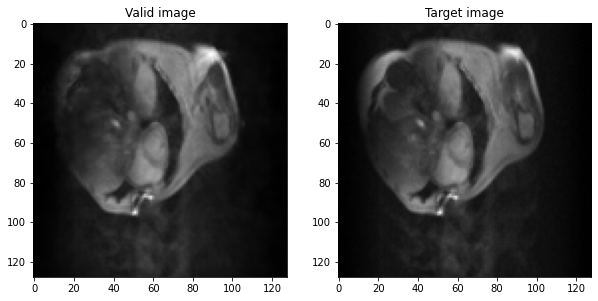

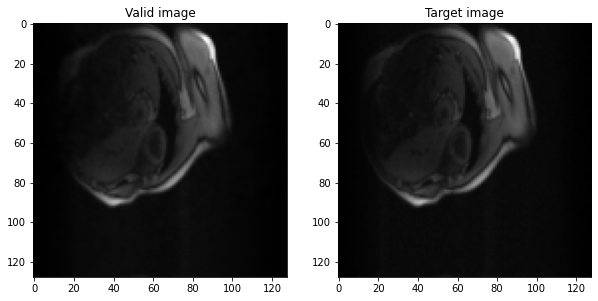

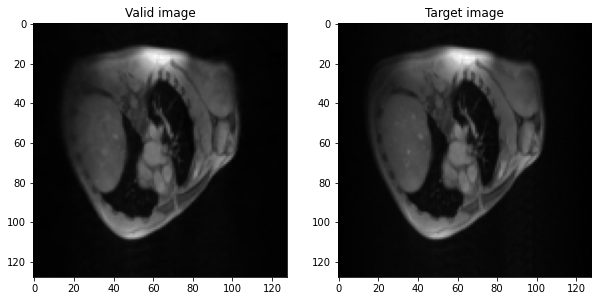

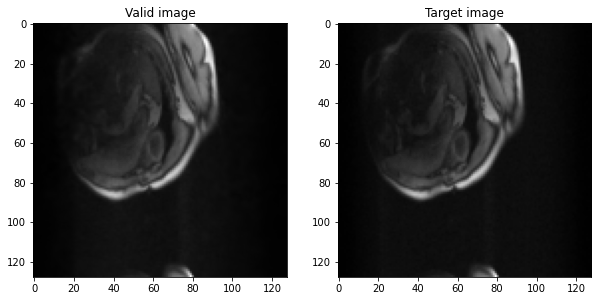

In [7]:
for index_b, (feature, target) in enumerate(test_loader):
    
    x_data = feature.to(device)
    y_true = target.to(device)

    y_fake = gen(x_data)
    
    #Visualization
    for idx in range(y_fake.shape[0]):
        visual(y_true[idx:idx+1,:,:,:], y_fake[idx:idx+1,:,:,:])